# Inventory Management using XGB

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data Cleaning

### 2018

In [2]:
# Try reading the CSV file with different encodings
encodings_to_try = ['utf-8', 'iso-8859-1', 'windows-1252', 'utf-16']

for encoding in encodings_to_try:
    try:
        df2018 = pd.read_csv("ZSR-2018-19.csv", encoding=encoding)
        print("CSV file read successfully using encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Failed to read CSV file using encoding:", encoding)

Failed to read CSV file using encoding: utf-8
CSV file read successfully using encoding: iso-8859-1


C:\Users\admin\AppData\Local\Temp\ipykernel_15100\4151265177.py:6: DtypeWarning: Columns (25,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df2018 = pd.read_csv("ZSR-2018-19.csv", encoding=encoding)


In [3]:
df2018

,FIN.YR,Payer,Payer Name,Plant,Commercial Invoice No.,Commercial Invoice Date,Invoice Type,Product- Material Code,Material Description,Quantity,...,Gross Value,Cust Matl No,Customer PO(SO),CITY,LR No,Forwarding Agent,Transporter Name,06AAACH7467D1ZO,Mode of Transport,HSN NUMBER
0,FY2018-19,100017,HONDA MOTORCYCLE & SCOOTER INDIA PV,6215,5003097724,04.04.2018,ZIF2,40002619,933/0 EQUALIZER CBS,300,...,9058.56,47651K389100,MNSR / 6500001795,"IMT Manesar, Gurgaon ( Haryana )",5006167,404043,Axpress Logistics India Pvt Ltd,06AAACH7467D1ZO,RD,87141090
1,FY2018-19,100017,HONDA MOTORCYCLE & SCOOTER INDIA PV,6215,5003097725,04.04.2018,ZIF2,40002619,933/0 EQUALIZER CBS,300,...,9058.56,47651K389100,MNSR / 6500001795,"IMT Manesar, Gurgaon ( Haryana )",5006168,404043,Axpress Logistics India Pvt Ltd,06AAACH7467D1ZO,RD,87141090
2,FY2018-19,100017,HONDA MOTORCYCLE & SCOOTER INDIA PV,6215,5003097727,04.04.2018,ZIF2,40001118,877/0 SPROCKET CAM,2400,...,49213.44,14321KRM8402,MNSR / 6500001795,"IMT Manesar, Gurgaon ( Haryana )",5006169,404043,Axpress Logistics India Pvt Ltd,06AAACH7467D1ZO,RD,87141090
3,FY2018-19,100017,HONDA MOTORCYCLE & SCOOTER INDIA PV,6215,5003097728,04.04.2018,ZIF2,40001118,877/0 SPROCKET CAM,2400,...,49213.44,14321KRM8402,MNSR / 6500001795,"IMT Manesar, Gurgaon ( Haryana )",5006170,404043,Axpress Logistics India Pvt Ltd,06AAACH7467D1ZO,RD,87141090
4,FY2018-19,100017,HONDA MOTORCYCLE & SCOOTER INDIA PV,6215,5003097729,04.04.2018,ZIF2,40001118,877/0 SPROCKET CAM,2400,...,49213.44,14321KRM8402,MNSR / 6500001795,"IMT Manesar, Gurgaon ( Haryana )",5006171,404043,Axpress Logistics India Pvt Ltd,06AAACH7467D1ZO,RD,87141090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,FY2018-19,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060012703,30.03.2019,ZIF2,40002703,935/0 STOPPER LEVER ASSY.,3000,...,61363.2,NaN,NaN,"CHENNAI,(Tamil Nadu)",NaN,NaN,NaN,NaN,RD,87141090
17996,FY2018-19,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060012707,30.03.2019,ZIF2,40002402,607/0 WHEEL STARTER,3000,...,593932.8,NaN,NaN,"CHENNAI,(Tamil Nadu)",NaN,NaN,NaN,NaN,RD,87141090
17997,FY2018-19,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060012708,30.03.2019,ZIF2,40002402,607/0 WHEEL STARTER,2880,...,570175.49,NaN,NaN,"CHENNAI,(Tamil Nadu)",NaN,NaN,NaN,NaN,RD,87141090
17998,FY2018-19,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060012709,30.03.2019,ZIF2,40002703,935/0 STOPPER LEVER ASSY.,4500,...,92044.8,NaN,NaN,"CHENNAI,(Tamil Nadu)",NaN,NaN,NaN,NaN,RD,87141090


In [4]:
df2018.columns

Index(['FIN.YR', ' Payer', 'Payer Name', 'Plant', 'Commercial Invoice No.',
       'Commercial Invoice Date', 'Invoice Type', 'Product- Material Code',
       'Material Description', 'Quantity', '  Basic Price', 'Discount amount',
       'Net amount ( Excluding Excise & Tax)', 'Net Value Excluding tax',
       'SGST TAX RATE', 'CGST TAX RATE', 'IGST TAX RATE',
       'State GST-OP Amount', 'Central GST-OP Amount',
       'Integrated GST-OP Amount', 'Packing Charge', 'TCS rate %',
       'TCS Amount', '      Gross Value', 'Cust Matl No', 'Customer PO(SO)',
       'CITY', 'LR No', 'Forwarding Agent', 'Transporter Name',
       '06AAACH7467D1ZO', 'Mode of Transport', 'HSN NUMBER'],
      dtype='object')

In [5]:
# Step 2: Identify repeated headings
# Assuming the header is the first row of the df2018Frame
header = df2018.columns.tolist()

# Create a boolean mask identifying rows that match the header
mask = (df2018.apply(lambda row: row.tolist() == header, axis=1))

# Step 3: Remove rows with repeated headings
cleaned_df2018 = df2018[~mask]

# Reset the index of the cleaned df2018Frame
cleaned_df2018.reset_index(drop=True, inplace=True)

In [6]:
cleaned_df2018

,FIN.YR,Payer,Payer Name,Plant,Commercial Invoice No.,Commercial Invoice Date,Invoice Type,Product- Material Code,Material Description,Quantity,...,Gross Value,Cust Matl No,Customer PO(SO),CITY,LR No,Forwarding Agent,Transporter Name,06AAACH7467D1ZO,Mode of Transport,HSN NUMBER
0,FY2018-19,100017,HONDA MOTORCYCLE & SCOOTER INDIA PV,6215,5003097724,04.04.2018,ZIF2,40002619,933/0 EQUALIZER CBS,300,...,9058.56,47651K389100,MNSR / 6500001795,"IMT Manesar, Gurgaon ( Haryana )",5006167,404043,Axpress Logistics India Pvt Ltd,06AAACH7467D1ZO,RD,87141090
1,FY2018-19,100017,HONDA MOTORCYCLE & SCOOTER INDIA PV,6215,5003097725,04.04.2018,ZIF2,40002619,933/0 EQUALIZER CBS,300,...,9058.56,47651K389100,MNSR / 6500001795,"IMT Manesar, Gurgaon ( Haryana )",5006168,404043,Axpress Logistics India Pvt Ltd,06AAACH7467D1ZO,RD,87141090
2,FY2018-19,100017,HONDA MOTORCYCLE & SCOOTER INDIA PV,6215,5003097727,04.04.2018,ZIF2,40001118,877/0 SPROCKET CAM,2400,...,49213.44,14321KRM8402,MNSR / 6500001795,"IMT Manesar, Gurgaon ( Haryana )",5006169,404043,Axpress Logistics India Pvt Ltd,06AAACH7467D1ZO,RD,87141090
3,FY2018-19,100017,HONDA MOTORCYCLE & SCOOTER INDIA PV,6215,5003097728,04.04.2018,ZIF2,40001118,877/0 SPROCKET CAM,2400,...,49213.44,14321KRM8402,MNSR / 6500001795,"IMT Manesar, Gurgaon ( Haryana )",5006170,404043,Axpress Logistics India Pvt Ltd,06AAACH7467D1ZO,RD,87141090
4,FY2018-19,100017,HONDA MOTORCYCLE & SCOOTER INDIA PV,6215,5003097729,04.04.2018,ZIF2,40001118,877/0 SPROCKET CAM,2400,...,49213.44,14321KRM8402,MNSR / 6500001795,"IMT Manesar, Gurgaon ( Haryana )",5006171,404043,Axpress Logistics India Pvt Ltd,06AAACH7467D1ZO,RD,87141090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,FY2018-19,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060012703,30.03.2019,ZIF2,40002703,935/0 STOPPER LEVER ASSY.,3000,...,61363.2,NaN,NaN,"CHENNAI,(Tamil Nadu)",NaN,NaN,NaN,NaN,RD,87141090
17996,FY2018-19,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060012707,30.03.2019,ZIF2,40002402,607/0 WHEEL STARTER,3000,...,593932.8,NaN,NaN,"CHENNAI,(Tamil Nadu)",NaN,NaN,NaN,NaN,RD,87141090
17997,FY2018-19,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060012708,30.03.2019,ZIF2,40002402,607/0 WHEEL STARTER,2880,...,570175.49,NaN,NaN,"CHENNAI,(Tamil Nadu)",NaN,NaN,NaN,NaN,RD,87141090
17998,FY2018-19,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060012709,30.03.2019,ZIF2,40002703,935/0 STOPPER LEVER ASSY.,4500,...,92044.8,NaN,NaN,"CHENNAI,(Tamil Nadu)",NaN,NaN,NaN,NaN,RD,87141090


In [7]:
cleaned_df2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 33 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   FIN.YR                                18000 non-null  object
 1    Payer                                18000 non-null  object
 2   Payer Name                            18000 non-null  object
 3   Plant                                 18000 non-null  object
 4   Commercial Invoice No.                18000 non-null  object
 5   Commercial Invoice Date               18000 non-null  object
 6   Invoice Type                          18000 non-null  object
 7   Product- Material Code                18000 non-null  object
 8   Material Description                  18000 non-null  object
 9   Quantity                              18000 non-null  object
 10    Basic Price                         18000 non-null  object
 11  Discount amount             

In [8]:
# Filter the DataFrame
df_filtered2018 = cleaned_df2018[(cleaned_df2018['Invoice Type'] == 'ZIF2') &
                      (cleaned_df2018['Product- Material Code'].str.startswith('400'))]

In [9]:
required_columns = ['Commercial Invoice Date','Product- Material Code', 'Quantity', 'Material Description', 'Payer Name']
data2018 = df_filtered2018[required_columns]

data2018

,Commercial Invoice Date,Product- Material Code,Quantity,Material Description,Payer Name
0,04.04.2018,40002619,300,933/0 EQUALIZER CBS,HONDA MOTORCYCLE & SCOOTER INDIA PV
1,04.04.2018,40002619,300,933/0 EQUALIZER CBS,HONDA MOTORCYCLE & SCOOTER INDIA PV
2,04.04.2018,40001118,2400,877/0 SPROCKET CAM,HONDA MOTORCYCLE & SCOOTER INDIA PV
3,04.04.2018,40001118,2400,877/0 SPROCKET CAM,HONDA MOTORCYCLE & SCOOTER INDIA PV
4,04.04.2018,40001118,2400,877/0 SPROCKET CAM,HONDA MOTORCYCLE & SCOOTER INDIA PV
...,...,...,...,...,...
17995,30.03.2019,40002703,3000,935/0 STOPPER LEVER ASSY.,"IFB INDUSTRIES LTD,CHENNAI"
17996,30.03.2019,40002402,3000,607/0 WHEEL STARTER,"IFB INDUSTRIES LTD,CHENNAI"
17997,30.03.2019,40002402,2880,607/0 WHEEL STARTER,"IFB INDUSTRIES LTD,CHENNAI"
17998,30.03.2019,40002703,4500,935/0 STOPPER LEVER ASSY.,"IFB INDUSTRIES LTD,CHENNAI"


### 2019

In [10]:
# Try reading the CSV file with different encodings
encodings_to_try = ['utf-8', 'iso-8859-1', 'windows-1252', 'utf-16']

for encoding in encodings_to_try:
    try:
        df2019 = pd.read_csv("ZSR-2019-20.csv", encoding=encoding)
        print("CSV file read successfully using encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Failed to read CSV file using encoding:", encoding)

Failed to read CSV file using encoding: utf-8
CSV file read successfully using encoding: iso-8859-1


In [11]:
# Step 2: Identify repeated headings
# Assuming the header is the first row of the df2019Frame
header = df2019.columns.tolist()

# Create a boolean mask identifying rows that match the header
mask = (df2019.apply(lambda row: row.tolist() == header, axis=1))

# Step 3: Remove rows with repeated headings
cleaned_df2019 = df2019[~mask]

# Reset the index of the cleaned df2019Frame
cleaned_df2019.reset_index(drop=True, inplace=True)

In [12]:
cleaned_df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 33 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   FIN.YR.                               14527 non-null  object 
 1    Payer                                14282 non-null  object 
 2   Payer Name                            14281 non-null  object 
 3   Plant                                 14281 non-null  float64
 4   Commercial Invoice No.                14281 non-null  float64
 5   Commercial Invoice Date               14281 non-null  object 
 6   Invoice Type                          14281 non-null  object 
 7   Product- Material Code                14281 non-null  float64
 8   Material Description                  14281 non-null  object 
 9   Quantity                              14282 non-null  object 
 10    Basic Price                         14281 non-null  object 
 11  Discount amount

In [13]:
cleaned_df2019['Product- Material Code'] = cleaned_df2019['Product- Material Code'].astype(str)

In [14]:
# Filter the DataFrame
df_filtered2019 = cleaned_df2019[(cleaned_df2019['Invoice Type'] == 'ZIF2') &
                      (cleaned_df2019['Product- Material Code'].str.startswith('400'))]

In [15]:
required_columns = ['Commercial Invoice Date', 'Product- Material Code', 'Quantity', 'Material Description', 'Payer Name']
data2019 = df_filtered2019[required_columns]

data2019

,Commercial Invoice Date,Product- Material Code,Quantity,Material Description,Payer Name
0,11.07.2019,40003812.0,60,1014/0 GEAR COMP. STARTER DRIVEN,HERO MOTOCORP LTD
1,01.04.2019,40003504.0,"4,800.00",1010/0 ROTOR SENSOR,IFB AUTOMOTIVE (P) LTD
2,03.04.2019,40003504.0,"4,800.00",1010/0 ROTOR SENSOR,IFB AUTOMOTIVE (P) LTD
3,06.04.2019,40002464.0,"6,000.00","576/0 BRACKET, UEGO SENSOR",IFB AUTOMOTIVE (P) LTD
4,09.04.2019,40002464.0,"3,600.00","576/0 BRACKET, UEGO SENSOR",IFB AUTOMOTIVE (P) LTD
...,...,...,...,...,...
14276,16.03.2020,40003755.0,"4,800.00",956/0 SPROCKET,"IFB INDUSTRIES LTD,CHENNAI"
14277,18.03.2020,40003755.0,"4,800.00",956/0 SPROCKET,"IFB INDUSTRIES LTD,CHENNAI"
14278,19.03.2020,40003495.0,"1,200.00",918/M SPROCKET,"IFB INDUSTRIES LTD,CHENNAI"
14279,19.03.2020,40003755.0,"4,800.00",956/0 SPROCKET,"IFB INDUSTRIES LTD,CHENNAI"


### 2020

In [16]:
# Try reading the CSV file with different encodings
encodings_to_try = ['utf-8', 'iso-8859-1', 'windows-1252', 'utf-16']

for encoding in encodings_to_try:
    try:
        df2020 = pd.read_csv("2020.csv", encoding=encoding)
        print("CSV file read successfully using encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Failed to read CSV file using encoding:", encoding)
        
df2020.head()

Failed to read CSV file using encoding: utf-8
CSV file read successfully using encoding: iso-8859-1


C:\Users\admin\AppData\Local\Temp\ipykernel_15100\3199936291.py:6: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df2020 = pd.read_csv("2020.csv", encoding=encoding)


,FIN.YR,Payer,Payer Name,Plant,Commercial Invoice No.,Commercial Invoice Date,Invoice Type,Product- Material Code,Material Description,Quantity,...,Cust Matl No,Customer PO(SO),CITY,LR No,Forwarding Agent,Transporter Name,Mode of Transport,HSN NUMBER,GSTIN NUMBER,Internal Cost(Local Curr)
0,FY2020-21,100230,LARSEN & TOUBRO LIMITED,6215.0,5.003132e+09,17.08.2020,ZIF2,40001002.0,037/0 CONTACT FINGER,"1,000.00",...,SL 71136,NaN,"AJWA & WAGHODIA JUNCTION, VADODARA",22100418,400405.0,OM LOGISTICS LTD,RD,85389000.0,24AAACL0140P6ZK,"18,450.00"
1,FY2020-21,100230,LARSEN & TOUBRO LIMITED,6215.0,5.003128e+09,16.05.2020,ZIF2,40001003.0,037/A CONTACT FINGER,"3,750.00",...,SL71137F,1553032716 Dt. 10.05,"AJWA & WAGHODIA JUNCTION, VADODARA",21819176,400405.0,OM LOGISTICS LTD,RD,85389000.0,24AAACL0140P6ZK,"65,700.00"
2,FY2020-21,100230,LARSEN & TOUBRO LIMITED,6215.0,5.003130e+09,08.07.2020,ZIF2,40001003.0,037/A CONTACT FINGER,"6,000.00",...,SL71137F,NaN,"AJWA & WAGHODIA JUNCTION, VADODARA",22022156,400405.0,OM LOGISTICS LTD,RD,85389000.0,24AAACL0140P6ZK,"1,05,120.00"
3,FY2020-21,100230,LARSEN & TOUBRO LIMITED,6215.0,5.003131e+09,03.08.2020,ZIF2,40001003.0,037/A CONTACT FINGER,"1,750.00",...,SL71137F,NaN,"AJWA & WAGHODIA JUNCTION, VADODARA",22120828,400405.0,OM LOGISTICS LTD,RD,85389000.0,24AAACL0140P6ZK,"35,105.00"
4,FY2020-21,100230,LARSEN & TOUBRO LIMITED,6215.0,5.003132e+09,14.08.2020,ZIF2,40001003.0,037/A CONTACT FINGER,"5,250.00",...,SL71137F,NaN,"AJWA & WAGHODIA JUNCTION, VADODARA",22100375,400405.0,OM LOGISTICS LTD,RD,85389000.0,24AAACL0140P6ZK,"1,05,315.00"


In [17]:
df2020['Product- Material Code'] = df2020['Product- Material Code'].astype(str)

# Filter the DataFrame
df_filtered3 = df2020[(df2020['Invoice Type'] == 'ZIF2') &
                      (df2020['Product- Material Code'].str.startswith('400'))]

# Check the columns of the filtered DataFrame
df_filtered3.columns

Index(['FIN.YR', ' Payer', 'Payer Name', 'Plant', 'Commercial Invoice No.',
       'Commercial Invoice Date', 'Invoice Type', 'Product- Material Code',
       'Material Description', 'Quantity', 'Basic Price', 'Discount amount',
       'Net amount ( Excluding Tax in Locl Curr)', 'Net Value Excluding tax',
       'SGST TAX RATE', 'CGST TAX RATE', 'IGST TAX RATE',
       'State GST-OP Amount', 'Central GST-OP Amount',
       'Integrated GST-OP Amount', 'Packing Charge', 'TCS rate %',
       'TCS Amount', '      Gross Value', 'Cust Matl No', 'Customer PO(SO)',
       'CITY', 'LR No', 'Forwarding Agent', 'Transporter Name',
       'Mode of Transport', 'HSN NUMBER', 'GSTIN NUMBER',
       'Internal Cost(Local Curr)'],
      dtype='object')

In [18]:
required_columns = ['Commercial Invoice Date', 'Product- Material Code', 'Quantity', 'Material Description', 'Payer Name']
df_result3 = df_filtered3[required_columns]

# Sort by "Product- Material Code" in ascending order
data2020 = df_result3.sort_values(by='Product- Material Code')

# Display the result
data2020

,Commercial Invoice Date,Product- Material Code,Quantity,Material Description,Payer Name
0,17.08.2020,40001002.0,"1,000.00",037/0 CONTACT FINGER,LARSEN & TOUBRO LIMITED
16,31.03.2021,40001003.0,"4,700.00",037/A CONTACT FINGER,SCHNEIDER ELECTRIC INDIA PRIVATE LT
14,02.03.2021,40001003.0,"1,750.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
13,12.02.2021,40001003.0,"3,000.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
12,30.01.2021,40001003.0,"1,250.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
...,...,...,...,...,...
17826,28.02.2021,40004388.0,"2,000.00","1027/0 FLANGE (EGR TUBE , ? 17X6 MM)",BORGWARNER EMISSIONS SYSTEMS IND.PV
17827,31.01.2021,40004389.0,500,"1031/0 SPROCKET DRIVE, 14T AFM","IFB INDUSTRIES LTD,Bangalore"
17828,28.02.2021,40004389.0,900,"1031/0 SPROCKET DRIVE, 14T AFM","IFB INDUSTRIES LTD,Bangalore"
17829,09.03.2021,40004415.0,117,1040/0 RING RR. PULSER,"IFB INDUSTRIES LTD,Binola"


### 2021

In [19]:
# Try reading the CSV file with different encodings
encodings_to_try = ['utf-8', 'iso-8859-1', 'windows-1252', 'utf-16']

for encoding in encodings_to_try:
    try:
        df2021 = pd.read_csv("2021.csv", encoding=encoding)
        print("CSV file read successfully using encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Failed to read CSV file using encoding:", encoding)
        
df2021.head()

Failed to read CSV file using encoding: utf-8
CSV file read successfully using encoding: iso-8859-1


C:\Users\admin\AppData\Local\Temp\ipykernel_15100\3969688607.py:6: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv("2021.csv", encoding=encoding)


,FIN.YR,Payer,Payer Name,Plant,Commercial Invoice No.,Commercial Invoice Date,Invoice Type,Product- Material Code,Material Description,Quantity,...,Cust Matl No,Customer PO(SO),CITY,LR No,Forwarding Agent,Transporter Name,Mode of Transport,HSN NUMBER,GSTIN NUMBER,Internal Cost(Local Curr)
0,FY2021-22,300267,"IFB INDUSTRIES LIMITED, DANKUNI",6215.0,5.003162e+09,31.03.2022,ZIF2,10011627.0,529/0-F&R-IS 513:2008 GRADE 'CR3'-2.6x99,225,...,NaN,NaN,"DT. HOOGHLY, WB",NaN,NaN,NaN,RD,72112350,19AAACI6561R5ZQ,"19,108.03"
1,FY2021-22,300267,"IFB INDUSTRIES LIMITED, DANKUNI",6725.0,5.060016e+09,31.03.2022,ZIF2,10013250.0,"607-IS: 513, CR2-4.9 X 125",790,...,NaN,NaN,"DT. HOOGHLY, WB",NaN,NaN,NaN,RD,72112350,19AAACI6561R5ZQ,"69,042.86"
2,FY2021-22,100595,HERO MOTOCORP LTD. (C.I.T.),6215.0,5.003154e+09,09.10.2021,ZIF2,10019322.0,CR2 SHEET 100X140X5,100,...,1211314,NaN,"PHASE-2, NH-11C, JAIPUR",11036983,NaN,NaN,RD,72112950,08AAACH0812J1ZW,"4,826.00"
3,FY2021-22,101153,AAM Auto Component (India) Pvt. Ltd,6215.0,5.003158e+09,31.12.2021,ZIF2,20026991.0,Touch probe TC52,2,...,NaN,NaN,"Taluka-Khed, District-Pune (MH)",NaN,NaN,NaN,RD,854370,27AAUCA2918A1ZR,"6,44,000.00"
4,FY2021-22,101153,AAM Auto Component (India) Pvt. Ltd,6215.0,5.003158e+09,31.12.2021,ZIF2,20026991.0,Touch probe TC52,1,...,NaN,NaN,"Taluka-Khed, District-Pune (MH)",NaN,NaN,NaN,RD,854370,27AAUCA2918A1ZR,"3,22,000.00"


In [20]:
df2021['Product- Material Code'] = df2021['Product- Material Code'].astype(str)

# Filter the DataFrame
df_filtered4 = df2021[(df2021['Invoice Type'] == 'ZIF2') &
                      (df2021['Product- Material Code'].str.startswith('400'))]

# Check the columns of the filtered DataFrame
df_filtered4.columns

Index(['FIN.YR', ' Payer', 'Payer Name', 'Plant', 'Commercial Invoice No.',
       'Commercial Invoice Date', 'Invoice Type', 'Product- Material Code',
       'Material Description', 'Quantity', 'Basic Price', 'Discount amount',
       'Net amount ( Excluding Tax in Locl Curr)', 'Net Value Excluding tax',
       'SGST TAX RATE', 'CGST TAX RATE', 'IGST TAX RATE',
       'State GST-OP Amount', 'Central GST-OP Amount',
       'Integrated GST-OP Amount', 'Packing Charge', 'TCS rate %',
       'TCS Amount', '      Gross Value', 'Cust Matl No', 'Customer PO(SO)',
       'CITY', 'LR No', 'Forwarding Agent', 'Transporter Name',
       'Mode of Transport', 'HSN NUMBER', 'GSTIN NUMBER',
       'Internal Cost(Local Curr)'],
      dtype='object')

In [21]:
required_columns = ['Commercial Invoice Date', 'Product- Material Code', 'Quantity', 'Material Description', 'Payer Name']
df_result4 = df_filtered4[required_columns]

# Sort by "Product- Material Code" in ascending order
data2021 = df_result4.sort_values(by='Product- Material Code')

# Display the result
data2021

,Commercial Invoice Date,Product- Material Code,Quantity,Material Description,Payer Name
5,21.02.2022,40001002.0,"1,250.00",037/0 CONTACT FINGER,Schneider Electric India Pvt. Limit
6,15.04.2021,40001002.0,"1,500.00",037/0 CONTACT FINGER,SCHNEIDER ELECTRIC INDIA PRIVATE LT
27,07.03.2022,40001003.0,"7,250.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
26,15.02.2022,40001003.0,"4,750.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
25,08.02.2022,40001003.0,"4,750.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
...,...,...,...,...,...
16971,06.03.2022,40004677.0,50,1053/0 FLANGE ? 28X 6 (3xM6 & POCKET),BORGWARNER EMISSIONS SYSTEMS IND.PV
16972,15.03.2022,40004677.0,123,1053/0 FLANGE ? 28X 6 (3xM6 & POCKET),BORGWARNER EMISSIONS SYSTEMS IND.PV
16973,28.03.2022,40004679.0,4,FLANGE XE1730060798A0 (PROTO),BORGWARNER EMISSIONS SYSTEMS IND.PV
16974,28.03.2022,40004680.0,4,FLANGE XE1730060803A0 (PROTO),BORGWARNER EMISSIONS SYSTEMS IND.PV


### 2022

In [22]:
# Try reading the CSV file with different encodings
encodings_to_try = ['utf-8', 'iso-8859-1', 'windows-1252', 'utf-16']

for encoding in encodings_to_try:
    try:
        df2022 = pd.read_csv("2022.csv", encoding=encoding)
        print("CSV file read successfully using encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Failed to read CSV file using encoding:", encoding)
        
df2022

Failed to read CSV file using encoding: utf-8
CSV file read successfully using encoding: iso-8859-1


,FIN.YR,Payer,Payer Name,Plant,Commercial Invoice No.,Commercial Invoice Date,Invoice Type,Product- Material Code,Material Description,Quantity,...,Cust Matl No,Customer PO(SO),CITY,LR No,Forwarding Agent,Transporter Name,Mode of Transport,HSN NUMBER,GSTIN NUMBER,Internal Cost(Local Curr)
0,FY2022-23,INDKA002,"IFB INDUSTRIES LTD.,MALUR",6215.0,5.003170e+09,05.09.2022,ZIF2,10013252.0,"1000-IS:513, CR2-5 X 140","1,098.00",...,10016962,NaN,MALUR,103665556,408132.0,SAFEXPRESS PRIVATE LIMITED,RD,72112950,29AAACI6561R1ZT,"93,829.68"
1,FY2022-23,INDKA002,"IFB INDUSTRIES LTD.,MALUR",6215.0,5.003171e+09,22.09.2022,ZIF2,10013252.0,"1000-IS:513, CR2-5 X 140","1,098.00",...,10016962,NaN,MALUR,NaN,408132.0,SAFEXPRESS PRIVATE LIMITED,RD,72112950,29AAACI6561R1ZT,"93,835.08"
2,FY2022-23,INDKA002,"IFB INDUSTRIES LTD.,MALUR",6215.0,5.003167e+09,27.07.2022,ZIF2,10013313.0,532/0 & 533/0-16MnCr5-3 X 157 MM,"1,223.00",...,NaN,NaN,MALUR,109351171,408132.0,SAFEXPRESS PRIVATE LIMITED,RD,72112950,29AAACI6561R1ZT,"1,30,524.68"
3,FY2022-23,100889,BORGWARNER EMISSIONS SYSTEMS IND.PV,6215.0,5.003179e+09,06.03.2023,ZIF2,10017251.0,1025/1034/1035/0- SUS430J1L:5.9 X114.0MM,40,...,NaN,NaN,"GURGAON, HARYANA",11256712,407716.0,SUNTEK AXPRESS INDIA PRIVATE LIMITE,RD,72112950,06AABCE7232N1ZI,"13,430.70"
4,FY2022-23,101153,AAM Auto Component (India) Pvt. Ltd,6215.0,5.003169e+09,30.08.2022,ZIF2,20026991.0,Touch probe TC52,1,...,NaN,NaN,"Taluka-Khed, District-Pune (MH)",NaN,700481.0,Others-Transport,RD,854370,27AAUCA2918A1ZR,"3,22,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19206,FY2022-23,101182,PN INTERNATIONAL PRIVATE LTD.,6215.0,5.003180e+09,29.03.2023,ZIF2,70002006.0,1068/0 FINE BLANKING TOOL,1,...,SRPO067-,22820019676,LUCKNOW(UP),ONLY FOR INV,700481.0,Others-Transport,RD,82073000,09AALCP1503H1ZI,"4,61,920.00"
19207,FY2022-23,101182,PN INTERNATIONAL PRIVATE LTD.,6215.0,5.003180e+09,29.03.2023,ZIF2,70002007.0,1069/0 FINE BLANKING TOOL,1,...,SRPO067>,NaN,LUCKNOW(UP),ONLY FOR INV,700481.0,Others-Transport,RD,82073000,09AALCP1503H1ZI,"4,93,000.00"
19208,FY2022-23,101421,IFB INDUSTRIES LIMITED (GOA),6215.0,5.003177e+09,31.01.2023,ZIF2,70002013.0,982/0 FINE BLANKING TOOL,1,...,CG62007702041,NaN,"VERNA, SALCETTE, GOA",NaN,700481.0,Others-Transport,RD,82073000,30AAACI6561R1ZA,"1,07,140.00"
19209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df2022['Product- Material Code'] = df2022['Product- Material Code'].astype(str)

# Filter the DataFrame
df_filtered5 = df2022[(df2022['Invoice Type'] == 'ZIF2') &
                      (df2022['Product- Material Code'].str.startswith('400'))]

# Check the columns of the filtered DataFrame
df_filtered5.columns

Index(['FIN.YR', ' Payer', 'Payer Name', 'Plant', 'Commercial Invoice No.',
       'Commercial Invoice Date', 'Invoice Type', 'Product- Material Code',
       'Material Description', 'Quantity', 'Basic Price', 'Discount amount',
       'Net amount ( Excluding Tax in Locl Curr)', 'Net Value Excluding tax',
       'SGST TAX RATE', 'CGST TAX RATE', 'IGST TAX RATE',
       'State GST-OP Amount', 'Central GST-OP Amount',
       'Integrated GST-OP Amount', 'Packing Charge', 'TCS rate %',
       'TCS Amount', '      Gross Value', 'Cust Matl No', 'Customer PO(SO)',
       'CITY', 'LR No', 'Forwarding Agent', 'Transporter Name',
       'Mode of Transport', 'HSN NUMBER', 'GSTIN NUMBER',
       'Internal Cost(Local Curr)'],
      dtype='object')

In [24]:
required_columns = ['Commercial Invoice Date', 'Product- Material Code', 'Quantity', 'Material Description', 'Payer Name']
df_result5 = df_filtered5[required_columns]

# Sort by "Product- Material Code" in ascending order
data2022 = df_result5.sort_values(by='Product- Material Code')

# Display the result
data2022

,Commercial Invoice Date,Product- Material Code,Quantity,Material Description,Payer Name
8,31.12.2022,40001002.0,"1,000.00",037/0 CONTACT FINGER,Schneider Electric India Pvt. Limit
28,13.03.2023,40001003.0,"1,000.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
27,11.03.2023,40001003.0,"3,750.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
26,04.03.2023,40001003.0,"5,000.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
24,09.02.2023,40001003.0,"7,250.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
...,...,...,...,...,...
19186,14.03.2023,40004942.0,12,Flange ?17 x 6-39-(2xM6) (PROTO),BORGWARNER EMISSIONS SYSTEMS IND.PV
19187,16.03.2023,40004943.0,12,Flange ?17 x 6-39-(2 SLOT 7X9) (PROTO),BORGWARNER EMISSIONS SYSTEMS IND.PV
19188,14.03.2023,40004944.0,12,Flange ?17 x 6-53-(2 SLOT 9X11) (PROTO),BORGWARNER EMISSIONS SYSTEMS IND.PV
19189,16.03.2023,40004948.0,477,1063/M CAM PLATE,SONA BLW PRECISION FORGING LTD.


### 2023

In [25]:
# Try reading the CSV file with different encodings
encodings_to_try = ['utf-8', 'iso-8859-1', 'windows-1252', 'utf-16']

for encoding in encodings_to_try:
    try:
        df2023 = pd.read_csv("2023.csv", encoding=encoding)
        print("CSV file read successfully using encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Failed to read CSV file using encoding:", encoding)
        
df2023

Failed to read CSV file using encoding: utf-8
CSV file read successfully using encoding: iso-8859-1


C:\Users\admin\AppData\Local\Temp\ipykernel_15100\1644707154.py:6: DtypeWarning: Columns (0,10,27,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df2023 = pd.read_csv("2023.csv", encoding=encoding)


,Payer,Payer Name,Plant,Commercial Invoice No.,Commercial Invoice Date,Invoice Type,Product- Material Code,Material Description,Quantity,Basic Price,...,Customer Po(ZTable),Customer PO(SO),CITY,LR No,Forwarding Agent,Transporter Name,Mode of Transport,HSN NUMBER,GSTIN NUMBER,Internal Cost(Local Curr)
0,100020,HERO MOTOCORP LTD,6215,5003182867,26.05.2023,ZIF2,40004559,1045/0-GEAR COMP STARTER DRIVEN,"4,548.00",158.42,...,NaN,Z330002452 / 22.05.2,GURGAON,11313266,407716.0,SUNTEK AXPRESS INDIA PRIVATE LIMITE,1,87141090,06AAACH0812J1Z0,"5,39,028.96"
1,100020,HERO MOTOCORP LTD,6215,5003191023,19.10.2023,ZIF2,40005487,988/0 SPROCKET CAM,30,22.7,...,NaN,Z310016576/18.08.202,GURGAON,NaN,407716.0,SUNTEK AXPRESS INDIA PRIVATE LIMITE,1,87141090,06AAACH0812J1Z0,424.8
2,100020,HERO MOTOCORP LTD,6215,5003192110,06.11.2023,ZIF2,40005487,988/0 SPROCKET CAM,50,22.7,...,NaN,Z310016576 / 18.08.2,GURGAON,NaN,700481.0,Others-Transport,1,87141090,06AAACH0812J1Z0,708
3,100020,HERO MOTOCORP LTD,6215,5003193164,23.11.2023,ZIF2,40005487,988/0 SPROCKET CAM,209,22.7,...,NaN,Z310016576 / 18.08.2,GURGAON,11450256,407716.0,SUNTEK AXPRESS INDIA PRIVATE LIMITE,1,87141090,06AAACH0812J1Z0,"2,959.44"
4,100022,IFB AUTOMOTIVE (P) LTD,6215,5003180333,06.04.2023,ZIF2,40003504,1010/0 ROTOR SENSOR,"4,000.00",20.4,...,-,5000015326 Amnd. 0 D,GURGAON,1.00E+11,408132.0,SAFEXPRESS PRIVATE LIMITED,RD,87141090,06AABCI2766H1ZM,"49,800.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21982,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060020369,29.03.2024,ZIF2,40002970,592/0 WHEEL STARTER,690,161.42,...,NaN,5000016557 Dt. 25.12,"SRIPEREMBUDUR,KANCHEEPURAM",11503541,407716.0,SUNTEK AXPRESS INDIA PRIVATE LIMITE,RD,87141090,33AAACI6561R2Z3,"64,094.10"
21983,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060020378,30.03.2024,ZIF2,40001134,893/0 STOPPER LEVER ASSY.,"2,000.00",18.64,...,NaN,5000016787 Amnd. 0 W,"SRIPEREMBUDUR,KANCHEEPURAM",5.02E+11,408132.0,SAFEXPRESS PRIVATE LIMITED,RD,87141090,33AAACI6561R2Z3,"27,240.00"
21984,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060020379,30.03.2024,ZIF2,40002988,945/0 STOPPER LEVER ASSY.,"1,200.00",14.66,...,NaN,5000016557 Amnd. 0,"SRIPEREMBUDUR,KANCHEEPURAM",11510630,407716.0,SUNTEK AXPRESS INDIA PRIVATE LIMITE,RD,87141090,33AAACI6561R2Z3,"14,808.00"
21985,INDTN001,"IFB INDUSTRIES LTD,CHENNAI",6725,5060020380,30.03.2024,ZIF2,40002970,592/0 WHEEL STARTER,690,161.42,...,NaN,5000016557 Dt. 25.12,"SRIPEREMBUDUR,KANCHEEPURAM",11510005,407716.0,SUNTEK AXPRESS INDIA PRIVATE LIMITE,RD,87141090,33AAACI6561R2Z3,"64,094.10"


In [26]:
df2023['Product- Material Code'] = df2023['Product- Material Code'].astype(str)

# Filter the DataFrame
df_filtered6 = df2023[(df2023['Invoice Type'] == 'ZIF2') &
                      (df2023['Product- Material Code'].str.startswith('400'))]

# Check the columns of the filtered DataFrame
df_filtered6.columns

Index([' Payer', 'Payer Name', 'Plant', 'Commercial Invoice No.',
       'Commercial Invoice Date', 'Invoice Type', 'Product- Material Code',
       'Material Description', 'Quantity', 'Basic Price', 'Discount amount',
       'Net amount ( Excluding Tax in Locl Curr)', 'Net Value Excluding tax',
       'SGST TAX RATE', 'CGST TAX RATE', 'IGST TAX RATE',
       'State GST-OP Amount', 'Central GST-OP Amount',
       'Integrated GST-OP Amount', 'Packing Charge', 'TCS(JTC) Tax Rate',
       'TCS(JTC) Amount', 'TCS rate %', 'TCS Amount', '      Gross Value',
       'Cust Matl No', 'Sales Order No.', 'Customer Po(ZTable)',
       'Customer PO(SO)', 'CITY', 'LR No', 'Forwarding Agent',
       'Transporter Name', 'Mode of Transport', 'HSN NUMBER', 'GSTIN NUMBER',
       'Internal Cost(Local Curr)'],
      dtype='object')

In [27]:
required_columns = ['Commercial Invoice Date', 'Product- Material Code', 'Quantity', 'Material Description', 'Payer Name']
df_result6 = df_filtered6[required_columns]

# Sort by "Product- Material Code" in ascending order
data2023 = df_result6.sort_values(by='Product- Material Code')

# Display the result
data2023

,Commercial Invoice Date,Product- Material Code,Quantity,Material Description,Payer Name
14259,31.05.2023,40001002,"1,000.00",037/0 CONTACT FINGER,Schneider Electric India Pvt. Limit
14231,29.04.2023,40001002,"1,000.00",037/0 CONTACT FINGER,Schneider Electric India Pvt. Limit
14255,27.05.2023,40001003,"2,250.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
14262,10.06.2023,40001003,"7,250.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
14210,10.04.2023,40001003,"1,250.00",037/A CONTACT FINGER,Schneider Electric India Pvt. Limit
...,...,...,...,...,...
9125,29.03.2024,40005797,500,655/0 HOLDER BRACKET (HONDA 2 POT ABS),ENDURANCE TECHNOLOGIES LTD(Disc.Bra
16742,16.01.2024,40005797,200,655/0 HOLDER BRACKET (HONDA 2 POT ABS),ENDURANCE TECHNOLOGIES LTD(R&D
20217,06.02.2024,40005810,12,656/0 PROTO,"IFB INDUSTRIES LTD,Binola"
16744,31.01.2024,40005817,200,654/0 HOLDER BRACKET MACH.HERO 2POT ACPB,ENDURANCE TECHNOLOGIES LTD(R&D


## Loading the lead time data

In [28]:
ldt_data = pd.read_csv('leadtime_data.csv')

ldt_data.head()

,Work Order,Packing batch qty,Lead time after Blanking
0,880/0,5000,6
1,893/0,3000,6
2,921/0,10000,4
3,487/0,300,8
4,488/0,300,8


## Concating the year wise data altogether

In [29]:
df = pd.concat([data2018, data2019, data2020, data2021, data2022, data2023])

df.isnull().sum()

Commercial Invoice Date    0
Product- Material Code     0
Quantity                   0
Material Description       0
Payer Name                 0
dtype: int64

# Data Wrangling

In [30]:
df.dtypes

Commercial Invoice Date    object
Product- Material Code     object
Quantity                   object
Material Description       object
Payer Name                 object
dtype: object

In [31]:
df['Date'] = pd.to_datetime(df['Commercial Invoice Date'], format="%d.%m.%Y", dayfirst=True)

# Convert 'Quantity' to numeric, handling commas and missing values
df['Quantity'] = df['Quantity'].astype(str).str.replace(',', '').astype(float)
# Convert 'Quantity' to integer
df['Quantity'] = df['Quantity'].astype(float).astype(int)  

# Round 'Product- Material Code' and convert to integer
df['Product- Material Code'] = df['Product- Material Code'].astype(float).round(0).astype(int) 

# Optionally convert 'Product- Material Code' to string if needed
df['Product- Material Code'] = df['Product- Material Code'].astype(str)

# Ensure 'Product- Material Code' is of the correct type and strip any extra whitespace
df['Product- Material Code'] = df['Product- Material Code'].astype(str).str.strip()

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107367 entries, 0 to 15323
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Commercial Invoice Date  107367 non-null  object        
 1   Product- Material Code   107367 non-null  object        
 2   Quantity                 107367 non-null  int32         
 3   Material Description     107367 non-null  object        
 4   Payer Name               107367 non-null  object        
 5   Date                     107367 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 5.3+ MB


In [33]:
df

,Commercial Invoice Date,Product- Material Code,Quantity,Material Description,Payer Name,Date
0,04.04.2018,40002619,300,933/0 EQUALIZER CBS,HONDA MOTORCYCLE & SCOOTER INDIA PV,2018-04-04
1,04.04.2018,40002619,300,933/0 EQUALIZER CBS,HONDA MOTORCYCLE & SCOOTER INDIA PV,2018-04-04
2,04.04.2018,40001118,2400,877/0 SPROCKET CAM,HONDA MOTORCYCLE & SCOOTER INDIA PV,2018-04-04
3,04.04.2018,40001118,2400,877/0 SPROCKET CAM,HONDA MOTORCYCLE & SCOOTER INDIA PV,2018-04-04
4,04.04.2018,40001118,2400,877/0 SPROCKET CAM,HONDA MOTORCYCLE & SCOOTER INDIA PV,2018-04-04
...,...,...,...,...,...,...
9125,29.03.2024,40005797,500,655/0 HOLDER BRACKET (HONDA 2 POT ABS),ENDURANCE TECHNOLOGIES LTD(Disc.Bra,2024-03-29
16742,16.01.2024,40005797,200,655/0 HOLDER BRACKET (HONDA 2 POT ABS),ENDURANCE TECHNOLOGIES LTD(R&D,2024-01-16
20217,06.02.2024,40005810,12,656/0 PROTO,"IFB INDUSTRIES LTD,Binola",2024-02-06
16744,31.01.2024,40005817,200,654/0 HOLDER BRACKET MACH.HERO 2POT ACPB,ENDURANCE TECHNOLOGIES LTD(R&D,2024-01-31


## Aggregating the data monthwise

In [34]:
df['Month'] = df['Date'].dt.month

df['Year'] = df['Date'].dt.year

In [35]:
monthly_data = df.groupby(['Year', 'Month', 'Material Description']).agg({'Quantity': 'sum'}).reset_index()

monthly_data

,Year,Month,Material Description,Quantity
0,2018,4,"0144/O,LEVER REV GEAR",5100
1,2018,4,0232/O UPPER PART ( FINISH),30000
2,2018,4,037/A CONTACT FINGER,8000
3,2018,4,037/B CONTACT FINGER,12000
4,2018,4,1000/0 WHEEL STARTER,8020
...,...,...,...,...
11169,2024,3,982/0 COUNTER WEIGHT PLATE BLDC,10000
11170,2024,3,983/M SPROCKET CAM,2400
11171,2024,3,987/0 ASSLY REVERSE LEVER,80
11172,2024,3,EXP64A NABE,5500


## Finding the products with order count of atleast 48 months

Generally 4 year data is required to predict future 1 year forecast

In [36]:
# Calculate the frequency of each product in the dataset
order_counts = monthly_data['Material Description'].value_counts()

# Filter out products with fewer than 48 orders
frequent_products = order_counts[order_counts >= 48].index

# Filter the original dataset to include only those frequent products
frequent_orders = monthly_data[monthly_data['Material Description'].isin(frequent_products)]

# Display the filtered data
data_filtered = frequent_orders
data_filtered

,Year,Month,Material Description,Quantity
2,2018,4,037/A CONTACT FINGER,8000
3,2018,4,037/B CONTACT FINGER,12000
4,2018,4,1000/0 WHEEL STARTER,8020
7,2018,4,1003/0 FACE DRIVE,36040
8,2018,4,1004/0 PLATE SIDE,20160
...,...,...,...,...
11150,2024,3,952/0 PLATE CLUTCH,33000
11152,2024,3,956/0 SPROCKET,24000
11154,2024,3,958/0 STOPR COMP.GEAR SHIFT DRUM,55000
11155,2024,3,959/0 EQUALIZER,29500


## Exploratory Data Analysis

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Styling for the plots
sns.set(style="whitegrid")

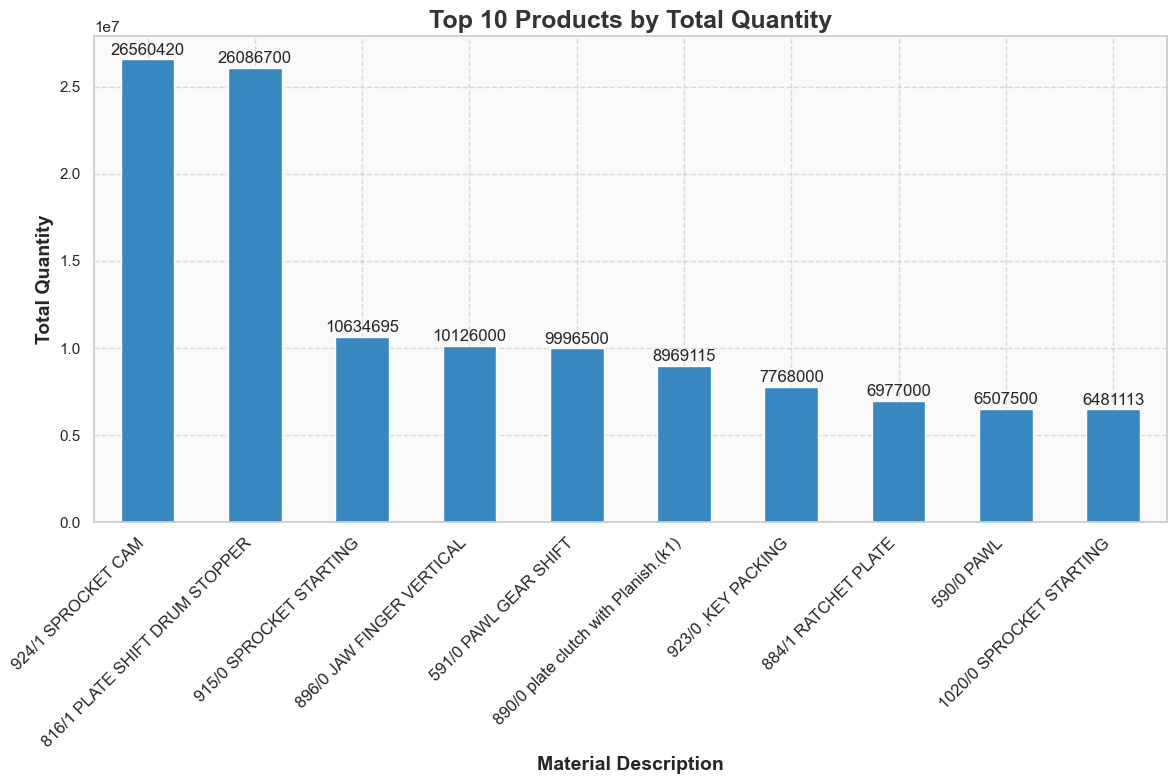

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a more visually appealing style
sns.set(style="whitegrid")

# Define a single color for the bars
color = sns.color_palette("Blues_d", 1)[0]

# Create the plot
plt.figure(figsize=(12, 8))
top_products.plot(kind='bar', color=color)

# Add a title and labels with enhanced font properties
plt.title('Top 10 Products by Total Quantity', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Material Description', fontsize=14, weight='bold')
plt.ylabel('Total Quantity', fontsize=14, weight='bold')

# Add gridlines for easier interpretation
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate the x-axis labels for better readability and adjust their alignment
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add annotations to display the values on top of the bars
for index, value in enumerate(top_products):
    plt.text(index, value + max(top_products) * 0.01, f'{int(value)}', ha='center', fontsize=12)

# Add a slight background color for the plot
plt.gca().set_facecolor('#f9f9f9')

# Show the plot
plt.tight_layout()
plt.show()

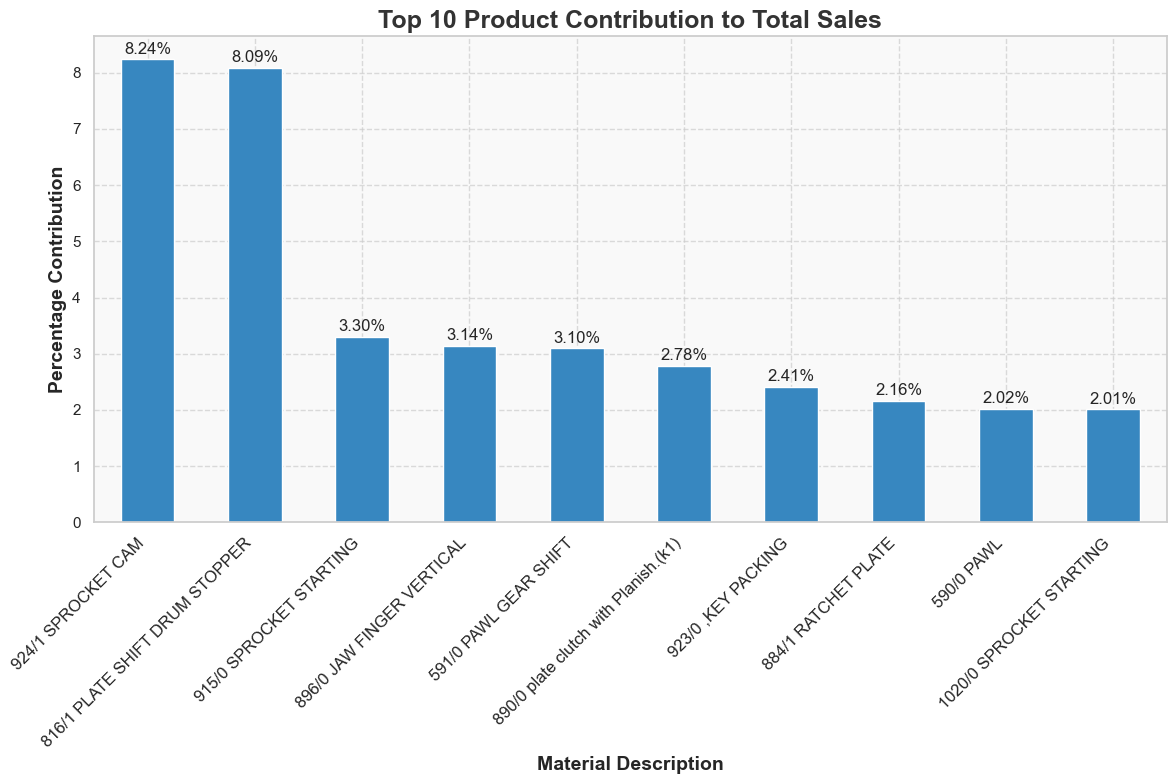

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a more visually appealing style
sns.set(style="whitegrid")

# Use a single color for the bars (soft blue)
color = sns.color_palette("Blues_d", 1)[0]

# Plot product contribution
plt.figure(figsize=(12, 8))
top_contributors = product_contribution.sort_values(ascending=False).head(10)
top_contributors.plot(kind='bar', color=color)

# Add a title and labels with enhanced font properties
plt.title('Top 10 Product Contribution to Total Sales', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Material Description', fontsize=14, weight='bold')
plt.ylabel('Percentage Contribution', fontsize=14, weight='bold')

# Add gridlines for easier interpretation
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate the x-axis labels for better readability and adjust their alignment
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add annotations to display the values on top of the bars
for index, value in enumerate(top_contributors):
    plt.text(index, value + 0.1, f'{value:.2f}%', ha='center', fontsize=12)

# Add a slight background color for the plot
plt.gca().set_facecolor('#f9f9f9')

# Show the plot
plt.tight_layout()
plt.show()

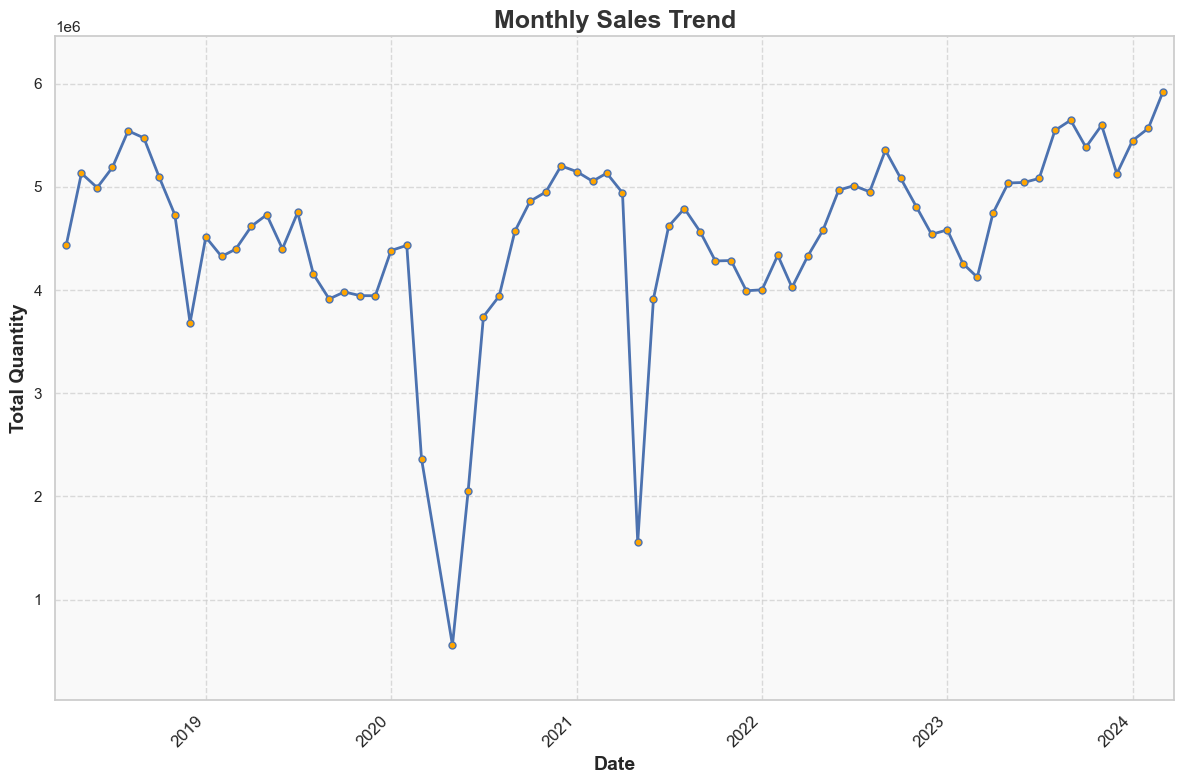

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a more visually appealing style
sns.set(style="whitegrid")

# Create the plot with a larger size and additional styling
plt.figure(figsize=(12, 8))

# Plot with a line style and markers for each data point
plt.plot(monthly_sales['Date'], monthly_sales['Quantity'], marker='o', color='b', linestyle='-', linewidth=2, markersize=5, markerfacecolor='orange')

# Add a title and labels with enhanced font properties
plt.title('Monthly Sales Trend', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Date', fontsize=14, weight='bold')
plt.ylabel('Total Quantity', fontsize=14, weight='bold')

# Format the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add gridlines for easier interpretation
plt.grid(True, linestyle='--', alpha=0.7)

# Set background color for the plot
plt.gca().set_facecolor('#f9f9f9')

# Add a slight margin to the plot
plt.margins(x=0.01, y=0.1)

# Tight layout to ensure no clipping of elements
plt.tight_layout()

# Show the plot
plt.show()

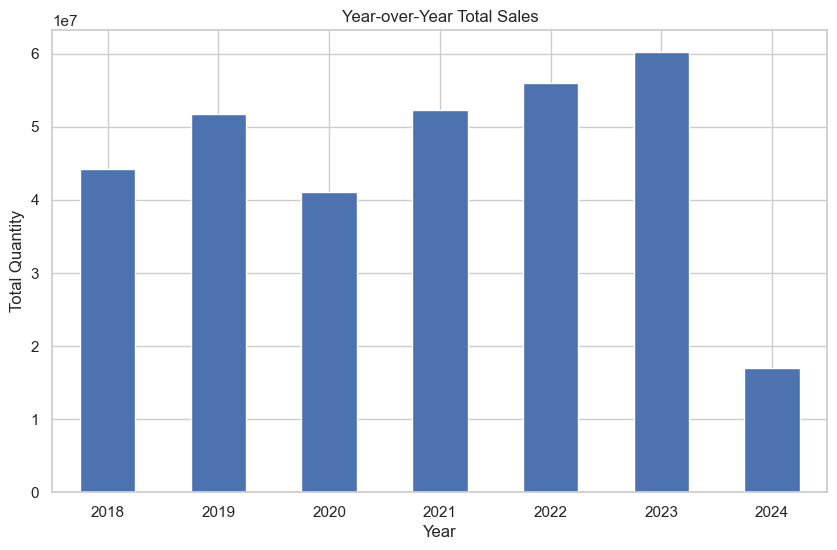

In [55]:
# Aggregate total quantity by Year
yearly_sales = df.groupby('Year')['Quantity'].sum()

# Plot year-over-year total sales
plt.figure(figsize=(10, 6))
yearly_sales.plot(kind='bar')
plt.title('Year-over-Year Total Sales')
plt.xlabel('Year')
plt.ylabel('Total Quantity')
plt.xticks(rotation=0)
plt.show()

In [72]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6644 entries, 2 to 11172
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Year                  6644 non-null   int32 
 1   Month                 6644 non-null   int32 
 2   Material Description  6644 non-null   object
 3   Quantity              6644 non-null   int32 
dtypes: int32(3), object(1)
memory usage: 181.7+ KB


In [73]:
data_filtered.describe()

,Year,Month,Quantity
count,6644.000000,6644.000000,6644.000000
mean,2020.824654,6.572848,38650.905328
std,1.763818,3.496364,64875.392083
min,2018.000000,1.000000,5.000000
25%,2019.000000,3.000000,5000.000000
50%,2021.000000,7.000000,16750.000000
75%,2022.000000,10.000000,44000.000000
max,2024.000000,12.000000,623700.000000


## Merging the quantity data with the lead time data

In [37]:
new_data = data_filtered.copy()

new_data['Work Order Match'] = new_data['Material Description'].str.extract(r'(^\d+/\d+)')

# Step 2: Merge the two DataFrames on 'Work Order' and 'Work Order Match'
merged_data = pd.merge(new_data, ldt_data, how='left', left_on='Work Order Match', right_on='Work Order')

# Step 3: Drop the 'Work Order Match' column (optional)
merged_data.drop(columns=['Work Order Match'], inplace=True)

# Step 4: Display the merged DataFrame
merged_data.head()

data_wwo = merged_data.dropna()

data_wwo

,Year,Month,Material Description,Quantity,Work Order,Packing batch qty,Lead time after Blanking
4,2018,4,1004/0 PLATE SIDE,20160,1004/0,2000.0,8.0
6,2018,4,1007/0 STOPPER LEVER ASSY.,6075,1007/0,3000.0,5.0
11,2018,4,162/0 VALVE SPRING DISC,13300,162/0,1400.0,6.0
13,2018,4,337/4 HOLDER,54912,337/4,5000.0,4.0
14,2018,4,487/0 PLATE VALVE INLET TS5,1200,487/0,300.0,8.0
...,...,...,...,...,...,...,...
6635,2024,3,947/0 Stopper Comp Gear Shift Cam,14000,947/0,2000.0,6.0
6636,2024,3,949/0 STOPPER LEVER ASSY.,1000,949/0,3000.0,5.0
6640,2024,3,956/0 SPROCKET,24000,956/0,6000.0,7.0
6641,2024,3,958/0 STOPR COMP.GEAR SHIFT DRUM,55000,958/0,2500.0,5.0


In [38]:
data_wwo["Material Description"].nunique()

52

## Number of running SKUs were found as 105

In [39]:
print("The number of SKUs to keep in stock as per 30 order count:", data_filtered['Material Description'].nunique())

The number of SKUs to keep in stock as per 30 order count: 105


## Segregating the data

In [40]:
data_filtered.sample(5)

,Year,Month,Material Description,Quantity
494,2018,7,503/0 TONGUE SPACER,44000
8535,2023,1,914/0 SPROCKET CAM,9120
9072,2023,4,"923/0 ,KEY PACKING",120000
1144,2018,11,592/0 WHEEL STARTER,1200
3957,2020,10,505/0 COUPLING,10000


In [41]:
work_order = '037/B CONTACT FINGER'

material_data = data_filtered[data_filtered['Material Description'] == work_order]

material_data.head()

,Year,Month,Material Description,Quantity
3,2018,4,037/B CONTACT FINGER,12000
150,2018,5,037/B CONTACT FINGER,43000
311,2018,6,037/B CONTACT FINGER,35000
470,2018,7,037/B CONTACT FINGER,35000
624,2018,8,037/B CONTACT FINGER,51000


# Model Selection

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

In [43]:
material_data['Date'] = pd.to_datetime(material_data[['Year', 'Month']].assign(DAY=1))
material_data.set_index('Date', inplace=True)
material_data = material_data[['Quantity']]

# Create lag features and rolling statistics
material_data['Lag_1'] = material_data['Quantity'].shift(1)
material_data['Lag_3'] = material_data['Quantity'].shift(3)
material_data['Lag_6'] = material_data['Quantity'].shift(6)
material_data['Lag_12'] = material_data['Quantity'].shift(12)
material_data['MA_3'] = material_data['Quantity'].rolling(window=3).mean().shift(1)
material_data['MA_6'] = material_data['Quantity'].rolling(window=6).mean().shift(1)
material_data.dropna(inplace=True)  # Drop rows with NaN values due to shifting

C:\Users\admin\AppData\Local\Temp\ipykernel_15100\4051105766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  material_data['Date'] = pd.to_datetime(material_data[['Year', 'Month']].assign(DAY=1))


In [44]:
material_data.head()

,Quantity,Lag_1,Lag_3,Lag_6,Lag_12,MA_3,MA_6
Date,,,,,,,
2019-04-01,36000,64000.0,22000.0,55000.0,12000.0,40666.666667,38833.333333
2019-05-01,30000,36000.0,36000.0,36000.0,43000.0,45333.333333,35666.666667
2019-06-01,30000,30000.0,64000.0,20000.0,35000.0,43333.333333,34666.666667
2019-07-01,30000,30000.0,36000.0,22000.0,35000.0,32000.000000,36333.333333
2019-08-01,50000,30000.0,30000.0,36000.0,51000.0,30000.000000,37666.666667


Initial Model Evaluation
XGBoost Model Metrics:
Mean Squared Error: 219438658.0699625
Mean Absolute Error: 12619.480631510416

RandomForest Model Metrics:
Mean Squared Error: 55829993.229166664
Mean Absolute Error: 6633.958333333333



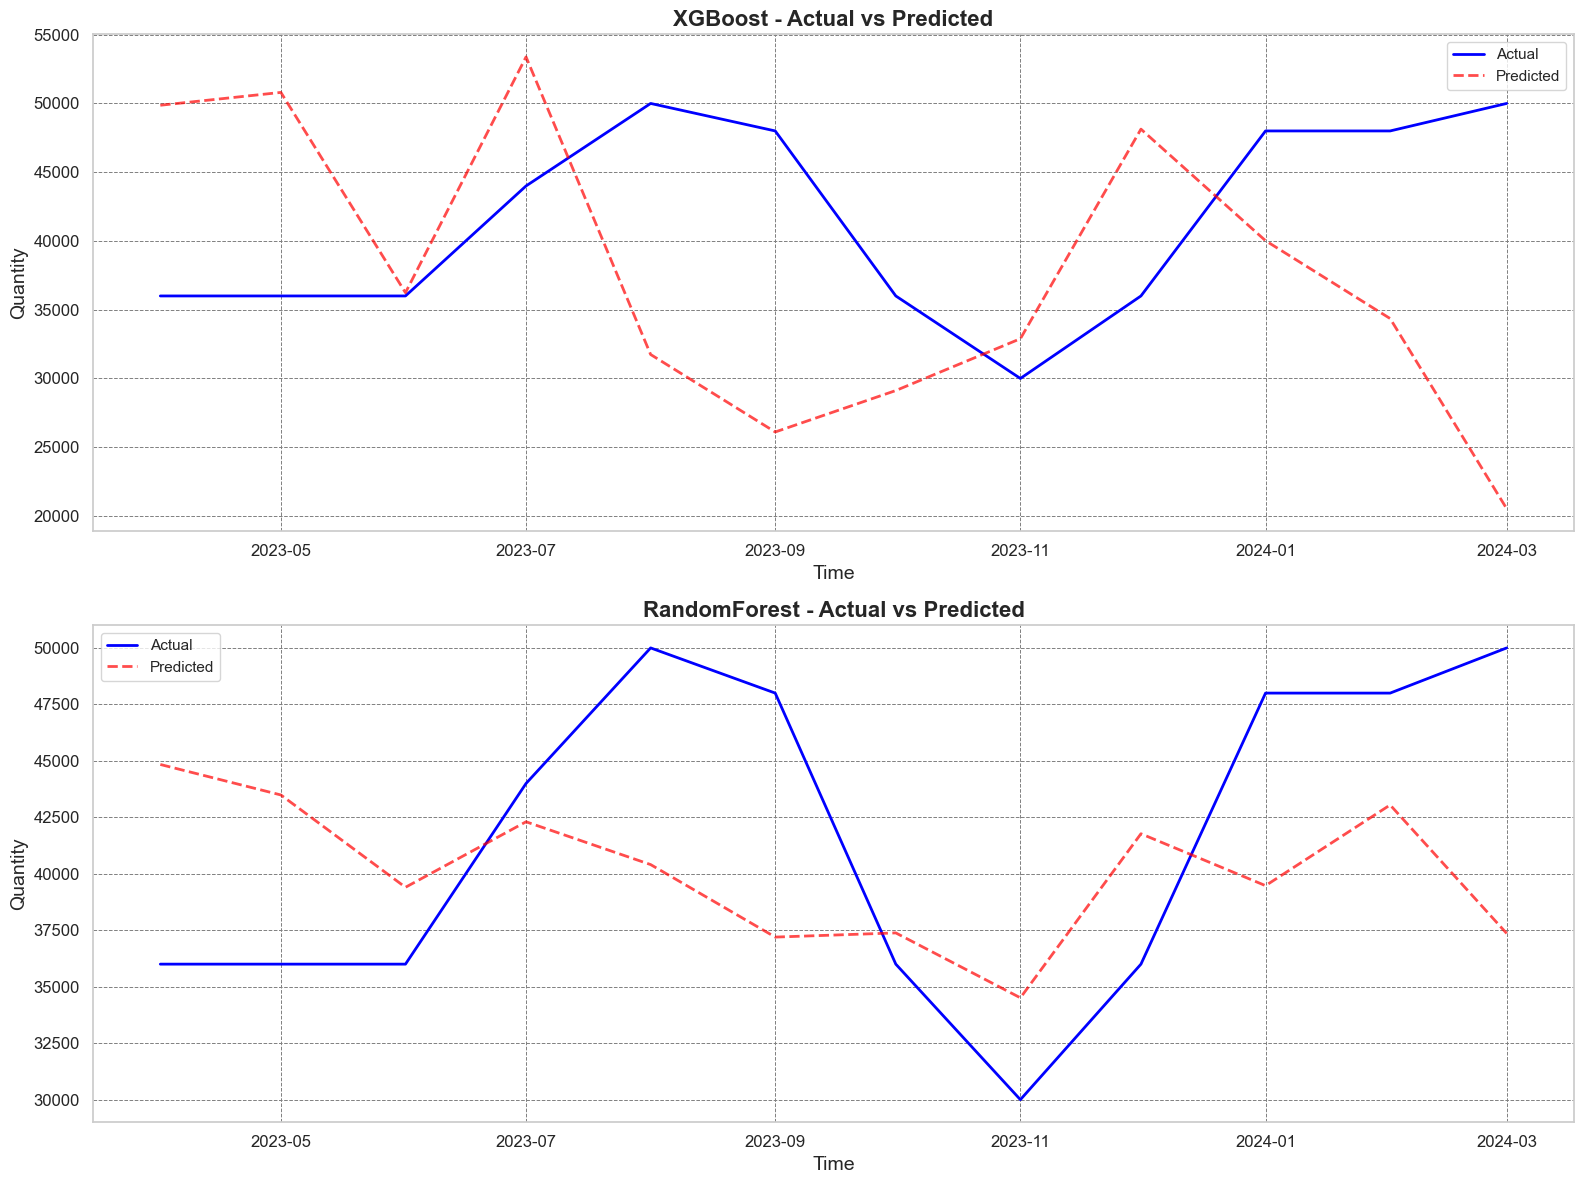

Best Model: RandomForest
Metrics: {'MSE': 55829993.229166664, 'MAE': 6633.958333333333}


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Assuming material_data is already prepared
# Features and target
X = material_data[['Lag_1', 'Lag_3', 'Lag_6', 'Lag_12', 'MA_3', 'MA_6']]
y = material_data['Quantity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize models
models = {
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror'),
    "RandomForest": RandomForestRegressor()
}

# Initial Model Evaluation
print("Initial Model Evaluation")

# Train models, evaluate, and plot results
results = {}
plt.figure(figsize=(16, 12))  # Larger figure for better readability

for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {"MSE": mse, "MAE": mae}
    print(f"{name} Model Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}\n")
    
    # Plotting the results
    plt.subplot(len(models), 1, i)  # Adjust the number of subplots based on the number of models
    plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linestyle='-', linewidth=2)
    plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--', linewidth=2, alpha=0.7)
    plt.title(f'{name} - Actual vs Predicted', fontsize=16, weight='bold')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Quantity', fontsize=14)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Identify the best model based on MAE or MSE
best_model_name = min(results, key=lambda x: results[x]['MAE'])  # or use 'MSE'
best_model_metrics = results[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Metrics: {best_model_metrics}")

## Hyperparameter Tuning

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best RandomForest Model Metrics:
Mean Squared Error: 6814507.14324338
Mean Absolute Error: 2212.4008000101753
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best XGBoost Model Metrics:
Mean Squared Error: 0.0013707478841145833
Mean Absolute Error: 0.033203125
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.9}

Best Model: XGBoost
Metrics: {'MSE': 0.0013707478841145833, 'MAE': 0.033203125}


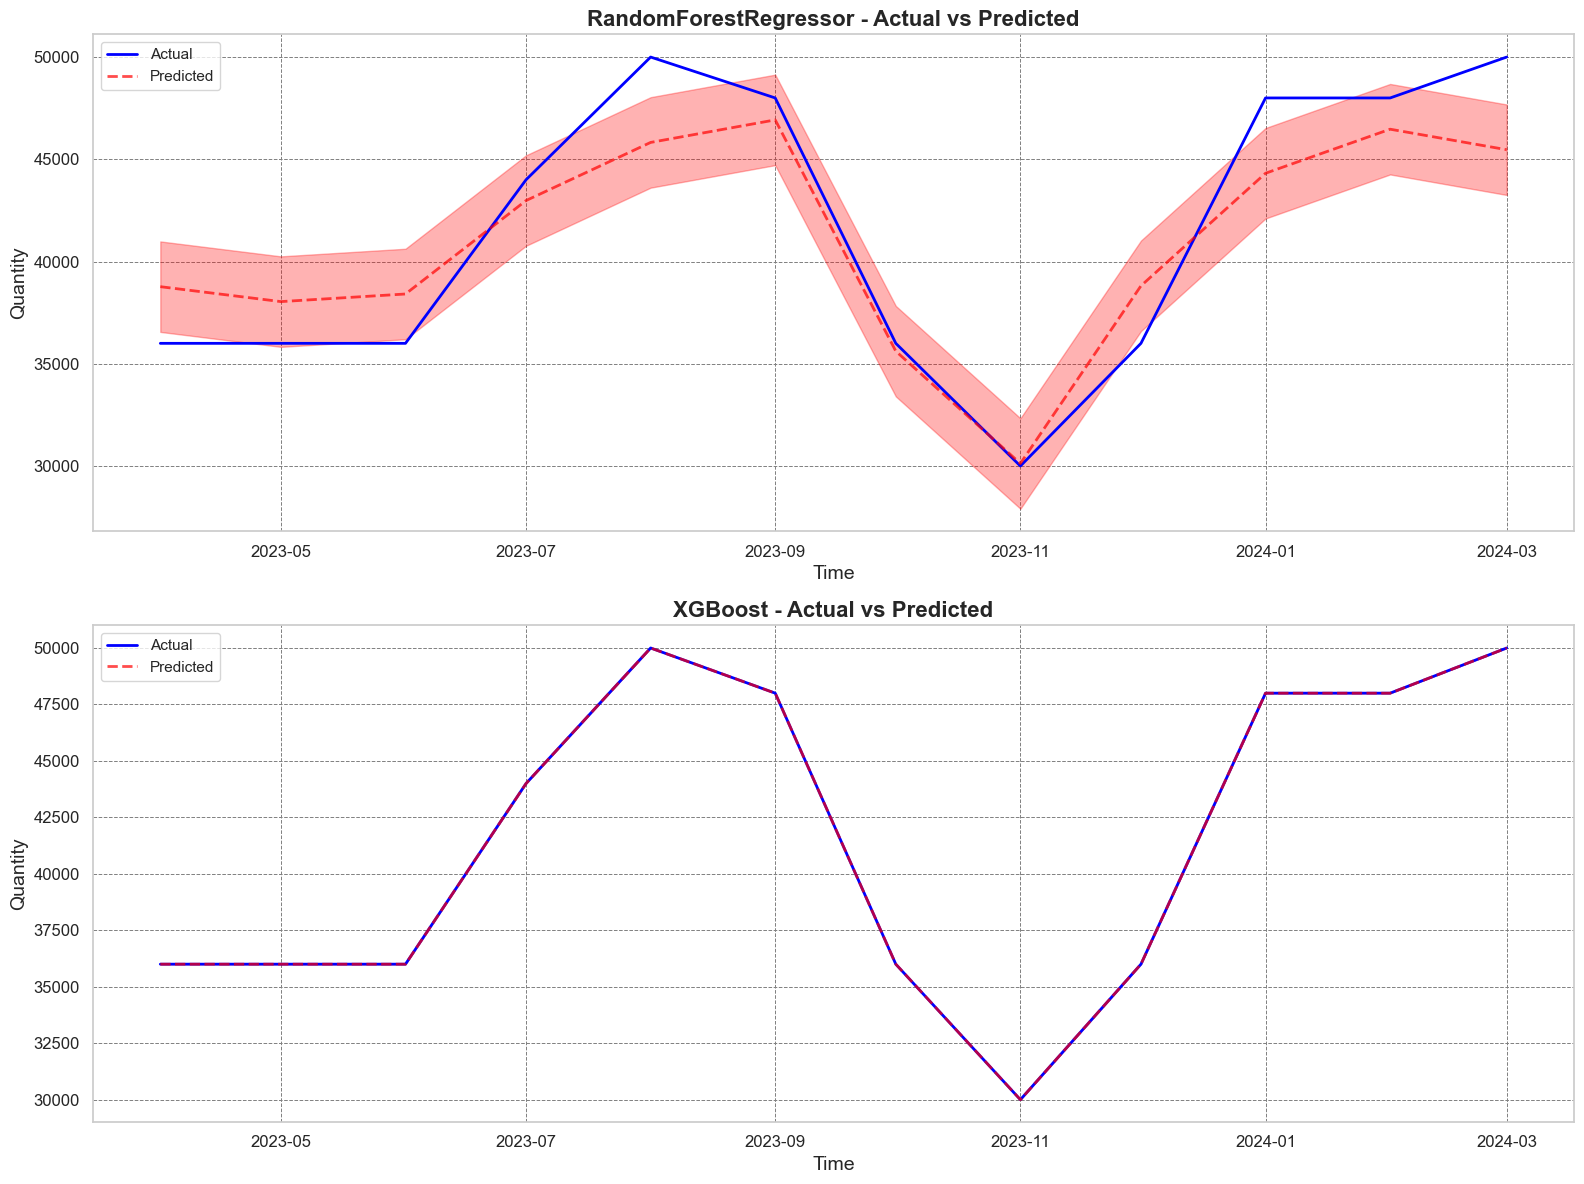

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Set the style for the plots
sns.set(style="whitegrid")

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameter tuning with GridSearchCV for RandomForest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor()
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
rf_grid_search.fit(X, y)

rf_best_model = rf_grid_search.best_estimator_
rf_y_pred_best = rf_best_model.predict(X_test)
rf_mse_tuned = mean_squared_error(y_test, rf_y_pred_best)
rf_mae_tuned = mean_absolute_error(y_test, rf_y_pred_best)

print(f"\nBest RandomForest Model Metrics:")
print(f"Mean Squared Error: {rf_mse_tuned}")
print(f"Mean Absolute Error: {rf_mae_tuned}")
print(f"Best Hyperparameters: {rf_grid_search.best_params_}\n")

# Hyperparameter tuning with GridSearchCV for XGBoost
xgb_param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}

xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
xgb_grid_search.fit(X, y)

xgb_best_model = xgb_grid_search.best_estimator_
xgb_y_pred_best = xgb_best_model.predict(X_test)
xgb_mse_tuned = mean_squared_error(y_test, xgb_y_pred_best)
xgb_mae_tuned = mean_absolute_error(y_test, xgb_y_pred_best)

print(f"\nBest XGBoost Model Metrics:")
print(f"Mean Squared Error: {xgb_mse_tuned}")
print(f"Mean Absolute Error: {xgb_mae_tuned}")
print(f"Best Hyperparameters: {xgb_grid_search.best_params_}\n")

# Determine the best model based on MAE or MSE
if rf_mae_tuned < xgb_mae_tuned:
    best_model_name = "RandomForest"
    best_model = rf_best_model
    best_model_metrics = {"MSE": rf_mse_tuned, "MAE": rf_mae_tuned}
else:
    best_model_name = "XGBoost"
    best_model = xgb_best_model
    best_model_metrics = {"MSE": xgb_mse_tuned, "MAE": xgb_mae_tuned}

print(f"Best Model: {best_model_name}")
print(f"Metrics: {best_model_metrics}")

# Initialize figures
plt.figure(figsize=(16, 12))  # Larger figure for better readability

# Plot for RandomForestRegressor
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linestyle='-', linewidth=2)
plt.plot(y_test.index, rf_y_pred_best, label='Predicted', color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.fill_between(y_test.index, rf_y_pred_best - rf_mae_tuned, rf_y_pred_best + rf_mae_tuned, color='red', alpha=0.3)
plt.title('RandomForestRegressor - Actual vs Predicted', fontsize=16, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot for XGBoost
plt.subplot(2, 1, 2)
plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linestyle='-', linewidth=2)
plt.plot(y_test.index, xgb_y_pred_best, label='Predicted', color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.fill_between(y_test.index, xgb_y_pred_best - xgb_mae_tuned, xgb_y_pred_best + xgb_mae_tuned, color='red', alpha=0.3)
plt.title('XGBoost - Actual vs Predicted', fontsize=16, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [47]:
# Step 4: Forecast the next fiscal year (April 2024 to March 2025) using GradientBoostingRegressor
forecast = []
last_known = X.iloc[-1].values  # Start from the last known material_data point

# Forecasting for the fiscal year: April 2024 to March 2025
for i in range(12):
    # Convert last_known to a DataFrame with the correct feature names
    last_known_df = pd.DataFrame([last_known], columns=X.columns)
    
    next_pred = best_model.predict(last_known_df)
    forecast.append(np.ceil(next_pred[0]))  # Apply ceiling to the forecasted value
    
    # Update the lag features and moving averages
    last_known = np.roll(last_known, -1)  # Shift the lag features
    last_known[-6:] = np.append(last_known[-5:], next_pred)  # Update lags and moving average

# Create forecast dates
forecast_dates = pd.date_range(start='2024-04-01', periods=12, freq='MS')
forecast_series = pd.Series(forecast, index=forecast_dates)

# Print the forecast with months
print(f"Forecast for Fiscal Year April 2024 to March 2025 of {work_order}:")
for month, quantity in forecast_series.items():
    print(f"{month.strftime('%B %Y')}: {int(quantity)}")  # Convert to int for cleaner display


Forecast for Fiscal Year April 2024 to March 2025 of 037/B CONTACT FINGER:
April 2024: 50000
May 2024: 33845
June 2024: 30409
July 2024: 32977
August 2024: 15993
September 2024: 28510
October 2024: 30516
November 2024: 32431
December 2024: 28516
January 2025: 33440
February 2025: 16136
March 2025: 28511


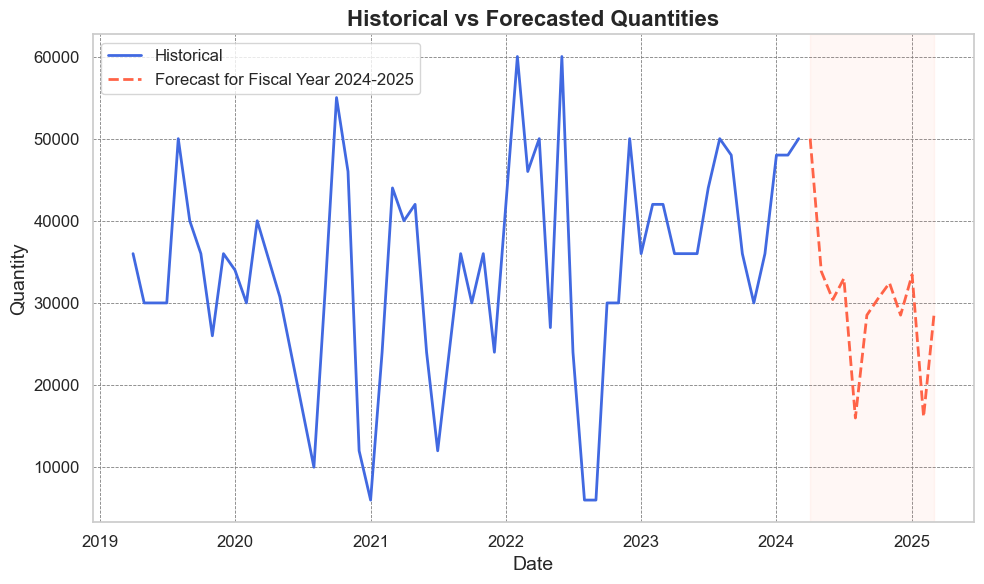

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and color palette
sns.set(style="whitegrid")

# Create the figure and plot
plt.figure(figsize=(10, 6))
plt.plot(material_data.index, material_data['Quantity'], label='Historical', color='royalblue', linewidth=2)
plt.plot(forecast_series.index, forecast_series, label='Forecast for Fiscal Year 2024-2025', color='tomato', linewidth=2, linestyle='--')

# Customize the plot with labels, title, and subtle grid
plt.title('Historical vs Forecasted Quantities', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='major', linestyle='--', linewidth=0.6, color='gray')

# Highlight the forecast period with a subtle shading
plt.axvspan(forecast_series.index.min(), forecast_series.index.max(), color='tomato', alpha=0.05)

# Enhance the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

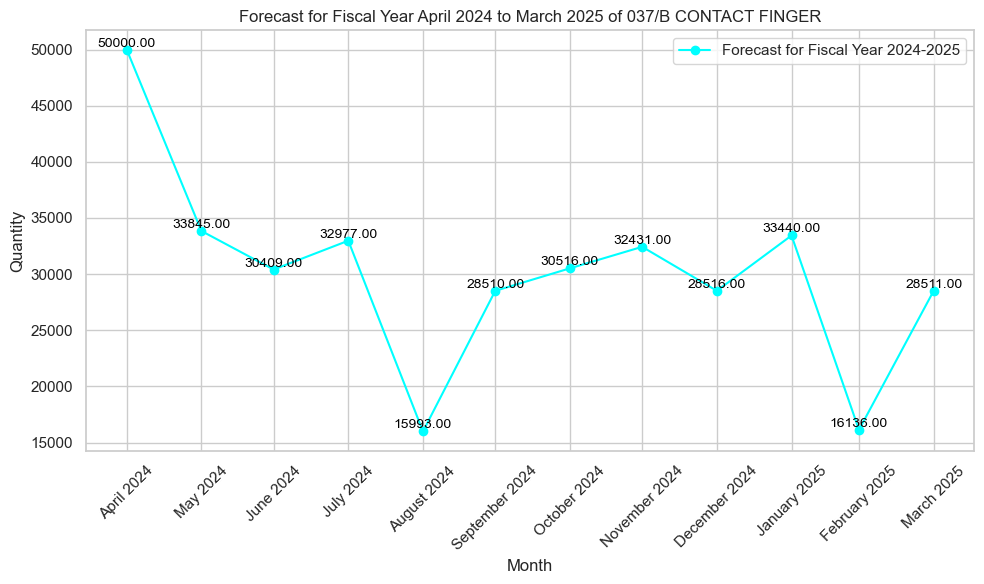

In [49]:
import matplotlib.pyplot as plt

# Create forecast dates
forecast_dates = pd.date_range(start='2024-04-01', periods=12, freq='M')
forecast_series = pd.Series(forecast, index=forecast_dates)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(forecast_series.index, forecast_series, marker='o', color='cyan', label='Forecast for Fiscal Year 2024-2025')

# Annotate each point with the quantity
for month, quantity in forecast_series.items():
    plt.text(month, quantity, f'{int(quantity):.2f}', ha='center', va='bottom', fontsize=10, color='black')

# Formatting the plot
plt.title(f'Forecast for Fiscal Year April 2024 to March 2025 of {work_order}')
plt.xlabel('Month')
plt.ylabel('Quantity')

# Set custom x-axis labels to show month names
plt.xticks(forecast_series.index, forecast_series.index.strftime('%B %Y'), rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.dates import DateFormatter, MonthLocator
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb

class PredictionApp:
    def __init__(self, root, data, ldt_data):
        self.root = root
        self.root.title("Future Quantity Prediction using XGBoost")
        self.data = data
        self.ldt_data = ldt_data

        # Styling and colors
        self.primary_color = "#2E86C1"
        self.secondary_color = "#AED6F1"
        self.background_color = "#F2F3F4"
        self.button_color = "#2874A6"

        self.style = ttk.Style()
        self.style.theme_use('clam')
        self.style.configure('TLabel', font=('Arial', 12), background=self.background_color)
        self.style.configure('TButton', font=('Arial', 12), background=self.button_color, foreground="white")
        self.style.map('TButton', background=[('active', self.secondary_color)])
        self.style.configure('TCombobox', font=('Arial', 12), width=40)

        self.root.configure(bg=self.background_color)

        main_frame = tk.Frame(self.root, bg=self.background_color, padx=20, pady=20)
        main_frame.grid(row=0, column=0, sticky='nsew')

        ttk.Label(main_frame, text="Material Description:").grid(row=0, column=0, padx=10, pady=10, sticky='w')
        self.material_entry = ttk.Combobox(main_frame, width=40)
        self.material_entry['values'] = list(self.data['Material Description'].unique())
        self.material_entry.grid(row=0, column=1, padx=10, pady=10)

        self.material_entry.bind('<FocusIn>', self.show_all_materials)
        self.material_entry.bind('<KeyRelease>', self.filter_materials)

        # Frame for buttons and metrics
        button_frame = tk.Frame(main_frame, bg=self.background_color)
        button_frame.grid(row=1, column=0, columnspan=2, padx=10, pady=10, sticky='w')

        self.predict_button = ttk.Button(button_frame, text="Predict", command=self.predict)
        self.predict_button.grid(row=0, column=0, pady=5, padx=5, sticky='w')

        self.planner_button = ttk.Button(button_frame, text="Production Planner", command=self.open_production_planner)
        self.planner_button.grid(row=0, column=1, pady=5, padx=5, sticky='w')

        self.mse_label = ttk.Label(button_frame, text="MSE: N/A")
        self.mse_label.grid(row=0, column=2, padx=10, pady=5)

        self.mae_label = ttk.Label(button_frame, text="MAE: N/A")
        self.mae_label.grid(row=0, column=3, padx=10, pady=5)

        plot_frame = tk.Frame(self.root, bg=self.background_color, padx=20, pady=10)
        plot_frame.grid(row=2, column=0, sticky='nsew')

        self.figure = plt.Figure(figsize=(14, 6), dpi=100)
        self.canvas = FigureCanvasTkAgg(self.figure, plot_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def show_all_materials(self, event):
        self.material_entry['values'] = list(self.data['Material Description'].unique())

    def filter_materials(self, event):
        current_input = self.material_entry.get().strip().lower()
        all_materials = list(self.data['Material Description'].unique())
        suggestions = [material for material in all_materials if current_input in material.lower()]
        self.material_entry['values'] = suggestions

    def predict(self):
        material_desc = self.material_entry.get()
        if not material_desc:
            messagebox.showerror("Input Error", "Please select a material description.")
            return

        material_data = self.data[self.data['Material Description'] == material_desc]
        payer_data = df[df['Material Description'] == material_desc]
        payer_name = payer_data['Payer Name'].unique()
        
        material_data['Date'] = pd.to_datetime(material_data[['Year', 'Month']].assign(DAY=1))
        material_data.set_index('Date', inplace=True)
        material_data = material_data[['Quantity']]

        material_data['Lag_1'] = material_data['Quantity'].shift(1)
        material_data['Lag_3'] = material_data['Quantity'].shift(3)
        material_data['Lag_6'] = material_data['Quantity'].shift(6)
        material_data['Lag_12'] = material_data['Quantity'].shift(12)
        material_data['MA_3'] = material_data['Quantity'].rolling(window=3).mean().shift(1)
        material_data['MA_6'] = material_data['Quantity'].rolling(window=6).mean().shift(1)
        material_data.dropna(inplace=True)

        # Features and target
        X = material_data[['Lag_1', 'Lag_3', 'Lag_6', 'Lag_12', 'MA_3', 'MA_6']]
        y = material_data['Quantity']
        
        param_grid = {
            'n_estimators': [500, 1000],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.7, 0.8, 0.9]
        }

        tscv = TimeSeriesSplit(n_splits=5)
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
        grid_search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
        grid_search.fit(X, y)

        best_model = grid_search.best_estimator_
        y_pred_best = best_model.predict(X)

        mse = mean_squared_error(y, y_pred_best)
        mae = mean_absolute_error(y, y_pred_best)

        self.mse_label.config(text=f"MSE: {mse:.2f}")
        self.mae_label.config(text=f"MAE: {mae:.2f}")

        forecast = []
        last_known = X.iloc[-1].values

        for i in range(12):
            next_pred = best_model.predict(last_known.reshape(1, -1))
            forecast.append(np.ceil(next_pred[0]))

            last_known = np.roll(last_known, -1)
            last_known[-6:] = np.append(last_known[-5:], next_pred)

        forecast_dates = pd.date_range(start='2024-04-01', periods=12, freq='MS')
        forecast_series = pd.Series(forecast, index=forecast_dates)

        self.figure.clear()
        ax = self.figure.add_subplot(111)

        # Enhance plot headings
        ax.plot(forecast_series.index, forecast_series, marker='o', color='royalblue', label='Forecast for Fiscal Year 2024-2025')

        for month, quantity in forecast_series.items():
            ax.text(month, quantity, f'{int(quantity)}', ha='center', va='bottom', fontsize=10, color='black')

        ax.set_title(f'Forecasted Quantities of {material_desc} for {payer_name}', fontsize=16, fontweight='bold', color=self.primary_color)
        ax.set_xlabel('Month', fontsize=14, color=self.primary_color)
        ax.set_ylabel('Quantity', fontsize=14, color=self.primary_color)

        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        ax.xaxis.set_major_locator(MonthLocator())

        ax.grid(True)
        ax.legend()

        self.canvas.draw()

    def open_production_planner(self):
        ProductionPlanner(self.root, self.ldt_data, self.button_color)

class ProductionPlanner:
    def __init__(self, root, ldt_data, button_color):
        self.top = tk.Toplevel(root)
        self.top.title("Production Planner")
        self.top.geometry("400x300")
        self.ldt_data = ldt_data
        self.button_color = button_color

        material_codes = sorted(self.ldt_data['Material Description'].unique())

        tk.Label(self.top, text="Material Description:", font=('Arial', 12)).grid(row=0, column=0, padx=10, pady=10, sticky='w')
        self.material_var = tk.StringVar()
        self.material_var.trace('w', self.update_combobox)
        self.material_entry = ttk.Combobox(self.top, textvariable=self.material_var, values=material_codes, font=('Arial', 10))
        self.material_entry.grid(row=0, column=1, padx=10, pady=10, sticky='ew')

        tk.Label(self.top, text="Available Quantity:", font=('Arial', 12)).grid(row=1, column=0, padx=10, pady=10, sticky='w')
        self.available_qty_entry = tk.Entry(self.top, font=('Arial', 10))
        self.available_qty_entry.grid(row=1, column=1, padx=10, pady=10, sticky='ew')

        tk.Label(self.top, text="Required Quantity:", font=('Arial', 12)).grid(row=2, column=0, padx=10, pady=10, sticky='w')
        self.required_qty_entry = tk.Entry(self.top, font=('Arial', 10))
        self.required_qty_entry.grid(row=2, column=1, padx=10, pady=10, sticky='ew')

        tk.Button(self.top, text="Calculate Lead Time", command=self.calculate_lead_time, bg=self.button_color, fg="white", font=('Arial', 12)).grid(row=3, column=1, padx=10, pady=10, sticky='e')

        # Label to display the result
        self.result_label = tk.Label(self.top, text="", font=('Arial', 12), fg="black")
        self.result_label.grid(row=4, column=0, columnspan=2, padx=10, pady=10)

    def update_combobox(self, *args):
        selected_material = self.material_var.get().strip().lower()
        matching_materials = [code for code in sorted(self.ldt_data['Material Description'].unique()) if selected_material in code.lower()]
        self.material_entry['values'] = matching_materials

    def calculate_lead_time(self):
        material_desc = self.material_entry.get()
        available_qty = int(self.available_qty_entry.get())
        required_qty = int(self.required_qty_entry.get())

        if material_desc and available_qty >= 0 and required_qty >= 0:
            material_data = self.ldt_data[self.ldt_data['Material Description'] == material_desc]

            if not material_data.empty:
                batch_qty = int(material_data['Packing batch qty'].iloc[0])
                lead_time_after_blanking = int(material_data['Lead time after Blanking'].iloc[0])

                shortfall_qty = max(0, required_qty - available_qty)
                required_batches = np.ceil(shortfall_qty / batch_qty) if batch_qty > 0 else 0
                expected_lead_time = required_batches * lead_time_after_blanking

                result_text = f"Shortfall Quantity: {shortfall_qty}\nExpected Lead Time: {expected_lead_time} days"
                self.result_label.config(text=result_text)
            else:
                self.result_label.config(text="Material Description not found.")
        else:
            self.result_label.config(text="Please enter valid quantities.")

if __name__ == "__main__":
    root = tk.Tk()
    app = PredictionApp(root, data_filtered, data_wwo)
    root.mainloop()

C:\Users\admin\AppData\Local\Temp\ipykernel_15100\62432581.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  material_data['Date'] = pd.to_datetime(material_data[['Year', 'Month']].assign(DAY=1))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\admin\AppData\Local\Temp\ipykernel_15100\62432581.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  material_data['Date'] = pd.to_datetime(material_data[['Year', 'Month']].assign(DAY=1))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
